----------------------
## IMPORTO LIBRERIE E CARICO FUNZIONI
-----------
-------------

LIBRERIE

In [1018]:
import pandas as pd ## dataframes
import yfinance as yf ## for finance
import datetime as dt
import numpy as np ## linear algebra
np.random.seed(11) ## for reproducibility
import matplotlib.pyplot as plt
from scipy import stats ## main python statistical package
import warnings
warnings.filterwarnings("ignore")
from statsmodels.tsa.stattools import grangercausalitytests
from pandas.plotting import lag_plot
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller, kpss, grangercausalitytests
from statsmodels.graphics.tsaplots import plot_acf
import statsmodels.api as sm
import random
import datetime


IMPORTO FUNZIONI

In [1019]:
def diff(X_t, dt):
    N = len(X_t)
    diff_X_t = []
    for i in range(N):
        if i==0:
            diff = (X_t[i+1]-X_t[i])/dt
            diff_X_t.append(diff)
        
        elif i==N-1:
            diff = (X_t[i]-X_t[i-1])/dt
            diff_X_t.append(diff)
            
        else:
            diff_fw = (X_t[i+1]-X_t[i])/dt
            diff_bw = (X_t[i]-X_t[i-1])/dt
            diff = 0.5*(diff_fw+diff_bw)
            diff_X_t.append(diff)
    return diff_X_t
def CrossCorrelationAnalysis(X, Y, maxlag,dt,color1,color2,nome1,nome2,figname):
    """
    Perform the lagged-cross-correlation analysis between two time series X(t) and Y(t).
    X, Y are two 1-d numpy arrays.
    dt is the time step of the time series (default 1 a.u.) - it could be specified w.r.t a given unit
    """
    
    ### Make sure the two time series are stationary
    ### Performing for example the Augmented Dickey-Fuller Test
    from statsmodels.tsa.stattools import adfuller
    result_X, result_Y = adfuller(X), adfuller(Y)
    if (result_X[1] > 0.05 or result_Y[1]>0.05):
        print("Time Series are not stationary")
        return
    else:
        ## we consider X(t+lag), Y(t)
        ## so that for lag<0 X preceeds Y and vice-versa.
        dim = len(X)
        lags = np.arange(-maxlag, maxlag+1, 1)
        lagged_cross_corr = []
        for lag in lags:
            XY = [(X[t+lag], Y[t]) for t in range(dim-np.abs(lag))]
            X_lagged = [el[0] for el in XY]
            Y_lagged = [el[1] for el in XY]
            lagged_cross_corr.append(stats.pearsonr(X_lagged, Y_lagged)[0])
            
        #plt.figure(figsize=(3, 3), dpi=180)
        lags_min = [l for l in lags if l<=0]
        lags_maj = [l for l in lags if l>=0]
        lcc_min = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]<=0]
        lcc_maj = [lagged_cross_corr[i] for i in range(len(lags)) if lags[i]>=0]
        plt.plot(lags_min, lcc_min, lw=3, color=color1)
        plt.plot(lags_maj, lcc_maj, lw=3, color=color2)
        plt.vlines(0, -1, 1, lw=1, ls='--', color='k')
        plt.xlabel('lag temporali',fontsize='16'), plt.ylabel('lagged-cross-correlation',fontsize='16')
        plt.text(-100, 0.8, str(nome1)+' precede '+str(nome2), color=color1,fontsize='16')
        plt.text(5, 0.8, str(nome2)+' precede '+str(nome1), color=color2,fontsize='16')
        corr=lcc_min+lcc_maj
        lag = np.argmax(corr) - maxlag
        if(lag >= 1 ):lag = lag-1
        plt.savefig(str(figname)+'.svg')
        plt.show()
        print('lag = ',lag)
        print('max corr = ',max(lagged_cross_corr))
        
    return lagged_cross_corr   

def normalize(data):
    """
    Normalize a dataset using min-max normalization.
    
    Parameters:
    -----------
    data : pandas.DataFrame or numpy.ndarray
        The dataset to be normalized.
    
    Returns:
    --------
    pandas.DataFrame or numpy.ndarray
        The normalized dataset.
    """
    # compute min and max values for each feature
    min_vals = np.min(data, axis=-1)
    max_vals = np.max(data, axis=-1)
    
    # normalize each feature using min-max normalization
    normalized_data = (data - min_vals) / (max_vals - min_vals)
    
    # convert the result to a pandas.DataFrame if the input was a DataFrame
    if isinstance(data, pd.DataFrame):
        normalized_data = pd.DataFrame(normalized_data, columns=data.columns, index=data.index)
    
    return normalized_data
    
### 1. Check whether the two processes are stationary
### Two common tests are 
### A. Augmented Dickey-Fuller (ADF) Test
### B. Kwiatkowski-Phillips-Schmidt-Shin (KPSS) Test


### ADF test is conducted with the following assumptions:
### Null Hypothesis (HO): Series is non-stationary, or series has a unit root.
### Alternate Hypothesis(HA): Series is stationary, or series has no unit root.
### If the null hypothesis is failed to be rejected, this test may provide evidence that the series is non-stationary.

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] > 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n")

### The KPSS test is conducted with the following assumptions.
### Null Hypothesis (HO): Series is trend stationary or series has no unit root.
### Alternate Hypothesis(HA): Series is non-stationary, or series has a unit root.
### Note: The hypothesis is reversed in the KPSS test compared to ADF Test.
    
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c', nlags="auto")
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','#Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] < 0.05:
        print("\n*** Time series is not stationary ***\n")
    else:
        print("\n*** Time series is stationary ***\n") 


-----------------
## CARICO DATASETS
------------
----------

In [1020]:
stmp = pd.read_csv('STM.csv')
tsmcp = pd.read_csv('TSMC34.SA.csv')
racep = pd.read_csv('RACE.csv')
SeP500p = pd.read_csv('SeP500.csv')

SISTEMO

In [1021]:
stmp = stmp.rename(columns={'Adj Close':'stm'})
tsmcp = tsmcp.rename(columns={'Adj Close':'tsmc'})
racep = racep.rename(columns={'Adj Close':'race'})
SeP500p = SeP500p.rename(columns={'Adj Close' : 'SeP500'})

stm = stmp['stm']
tsmc = tsmcp['tsmc']
race = racep['race']
SeP500 = SeP500p['SeP500']

PLOT DATA


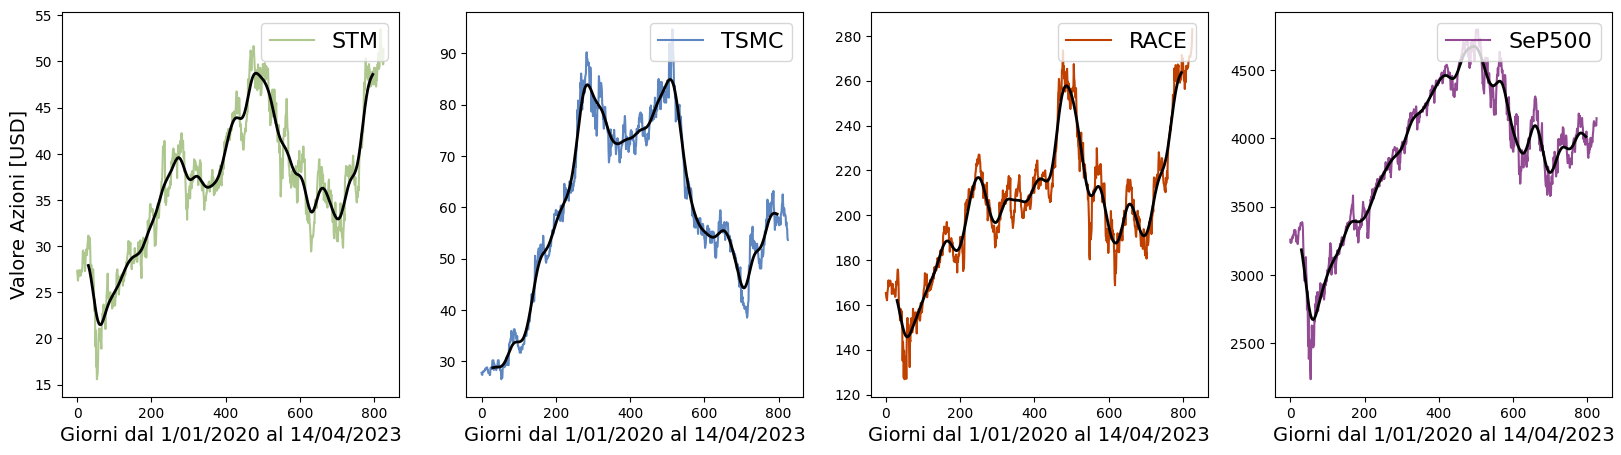

In [1022]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
anni=list(range(0,826))
ax[0].plot(anni,stm,color='#9AB973',label='STM',alpha=0.8)
ax[0].plot(anni,stm.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[0].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[0].set_ylabel('Valore Azioni [USD]',fontsize='14')
ax[1].plot(anni,tsmc,color='#5E86C1',label='TSMC')
ax[1].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[1].plot(anni,tsmc.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[2].plot(anni,race,color='#C04000',label='RACE')
ax[2].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[2].plot(anni,race.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[3].plot(anni,SeP500,color='#660066',label='SeP500',alpha=0.7)
ax[3].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[3].plot(anni,SeP500.rolling(60, center=True,win_type='hamming').mean(),color='black',lw=2)
ax[0].legend(fontsize='16',loc='upper right'),ax[1].legend(fontsize='16',loc='upper right'),ax[2].legend(fontsize='16',loc='upper right'),ax[3].legend(fontsize='16',loc='upper right')
plt.savefig('grafici.svg')

-------------
## DETRENDING
------
----------

DIFFERENZIO

MEDIA MOBILE

In [1024]:
#lag top 60
lag=60
stm_medio = stm.rolling(lag, center=True,win_type='hamming').mean()
tsmc_medio = tsmc.rolling(lag,center=True,win_type='hamming').mean()
race_medio = race.rolling(lag, center=True, win_type='hamming').mean()
SeP500_medio = SeP500.rolling(lag, center=True, win_type='hamming').mean()

dt=4
d_stm = stm.rolling(dt,center=True,win_type='hamming').mean() - stm_medio
d_tsmc = tsmc.rolling(dt,center=True,win_type='hamming').mean() - tsmc_medio
d_race = race.rolling(dt,center=True,win_type='hamming').mean() - race_medio
d_SeP500 = SeP500.rolling(dt, center=True,win_type='hamming').mean() - SeP500_medio

d_stm=np.nan_to_num(d_stm)
d_tsmc=np.nan_to_num(d_tsmc)
d_race=np.nan_to_num(d_race)
d_SeP500=np.nan_to_num(d_SeP500)

NORMALIZZO

In [1025]:
d_stm = normalize(d_stm)
d_tsmc = normalize(d_tsmc)
d_race = normalize (d_race)
d_SeP500 = normalize (d_SeP500)


PLOT DETRENDING

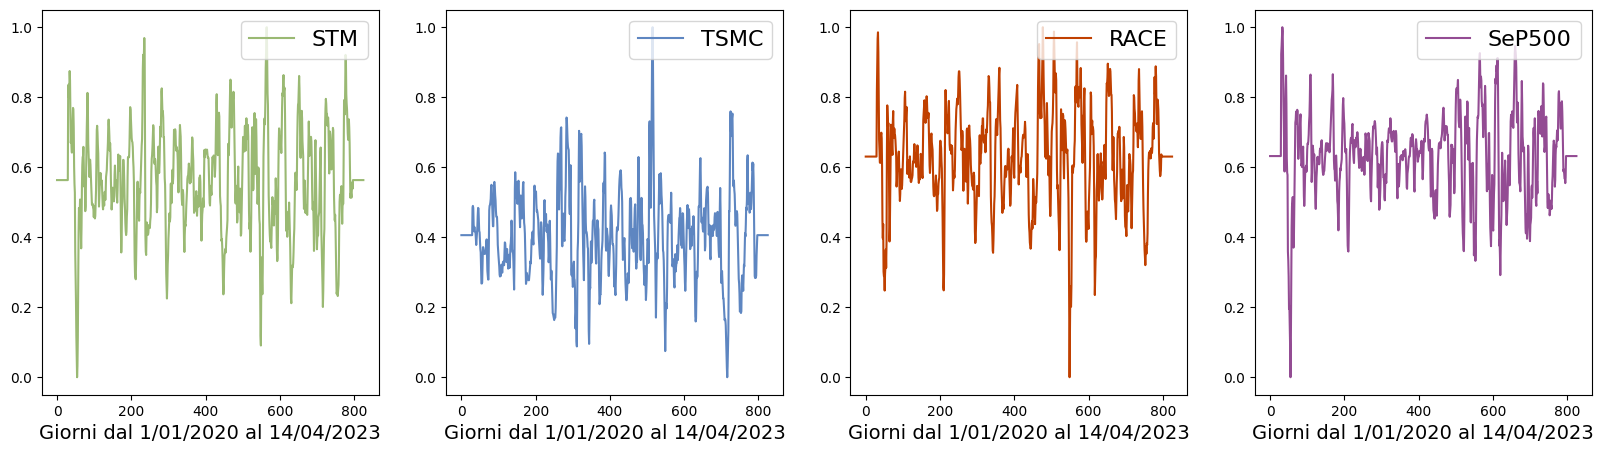

In [1026]:
fig, ax = plt.subplots(nrows=1,ncols=4,figsize=(20,5))
anni=list(range(0,826))
ax[0].plot(anni,d_stm,color='#9AB973',label='STM')
ax[0].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[1].plot(anni,d_tsmc,color='#5E86C1',label='TSMC')
ax[1].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[2].plot(anni,d_race,color='#C04000',label='RACE')
ax[2].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[3].plot(anni,d_SeP500,color='#660066',label='SeP500',alpha=0.7)
ax[3].set_xlabel('Giorni dal 1/01/2020 al 14/04/2023',fontsize='14')
ax[0].legend(fontsize='16',loc='upper right'),ax[1].legend(fontsize='16',loc='upper right'),ax[2].legend(fontsize='16',loc='upper right'),ax[3].legend(fontsize='16',loc='upper right')
plt.savefig('grafici1.svg')

TESTO STAZIONARIETA' CON ADF E KPSS TEST

In [1027]:
print('---------------------')
print('STAZIONARIETA\' STM :')
print('---------------------')
adf_test(d_stm)
kpss_test(d_stm)
print('----------------------')
print('STAZIONARIETA\' TSMC :')
print('----------------------')
adf_test(d_tsmc)
kpss_test(d_tsmc)
print('----------------------')
print('STAZIONARIETA\' RACE :')
print('----------------------')
adf_test(d_race)
kpss_test(d_race)
print('------------------------')
print('STAZIONARIETA\' SeP500 :')
print('------------------------')
adf_test(d_SeP500)
kpss_test(d_SeP500)

---------------------
STAZIONARIETA' STM :
---------------------
Results of Dickey-Fuller Test:
Test Statistic                -9.333471e+00
p-value                        9.195118e-16
#Lags Used                     1.300000e+01
Number of Observations Used    8.120000e+02
Critical Value (1%)           -3.438429e+00
Critical Value (5%)           -2.865106e+00
Critical Value (10%)          -2.568669e+00
dtype: float64

*** Time series is stationary ***

Results of KPSS Test:
Test Statistic            0.010505
p-value                   0.100000
#Lags Used               16.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64

*** Time series is stationary ***

----------------------
STAZIONARIETA' TSMC :
----------------------
Results of Dickey-Fuller Test:
Test Statistic                -7.909851e+00
p-value                        3.974917e-12
#Lags Used                     1.300000e

--------------
## CROSS CORRELATION
----------
-----------

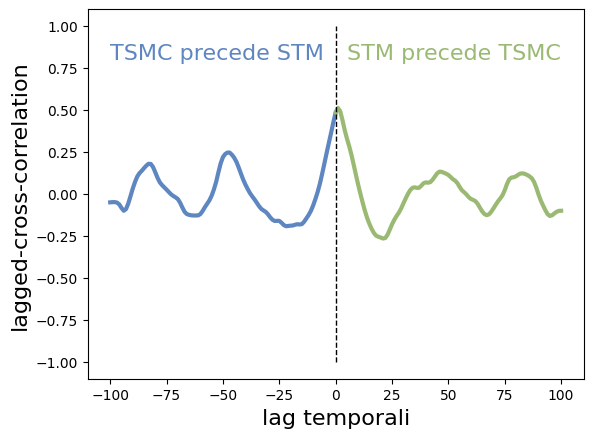

lag =  1
max corr =  0.5116665815797322


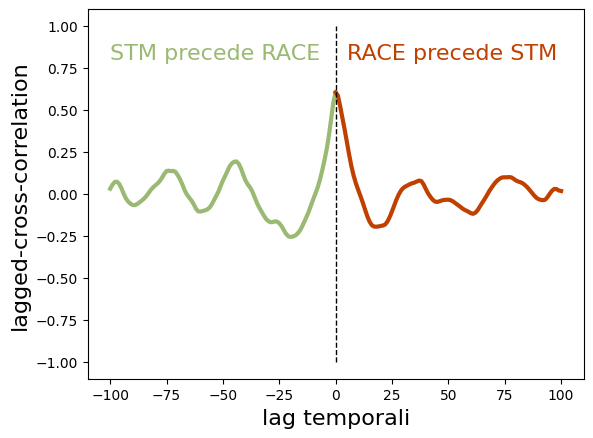

lag =  0
max corr =  0.6042185130064828


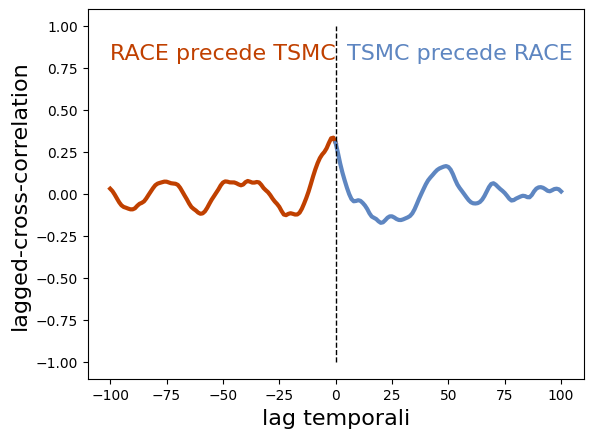

lag =  -1
max corr =  0.33475378028751424


In [1028]:
lag=100
corr1 = CrossCorrelationAnalysis(d_tsmc,d_stm, lag,1,color1='#5E86C1',color2='#9AB973',nome1='TSMC',nome2='STM',figname='corr1')
corr2 = CrossCorrelationAnalysis(d_stm,d_race, lag,1,color1='#9AB973',color2='#C04000',nome1='STM',nome2='RACE',figname='corr2')
corr3 = CrossCorrelationAnalysis(d_race,d_tsmc, lag,1,color1='#C04000',color2='#5E86C1',nome1='RACE',nome2='TSMC',figname='corr3')


---------------------
## SHUFFLE DATI E CROSS CORRELATION

--------------


In [1029]:
import random

def shuffle_copy(arr):
    arr_copy = arr.copy()
    random.shuffle(arr_copy)
    return arr_copy


In [1030]:
d_stm_shuffle = shuffle_copy(d_stm)
d_tsmc_shuffle = shuffle_copy(d_tsmc)
d_race_shuffle = shuffle_copy(d_race)
d_SeP500_shuffle = shuffle_copy(d_SeP500)


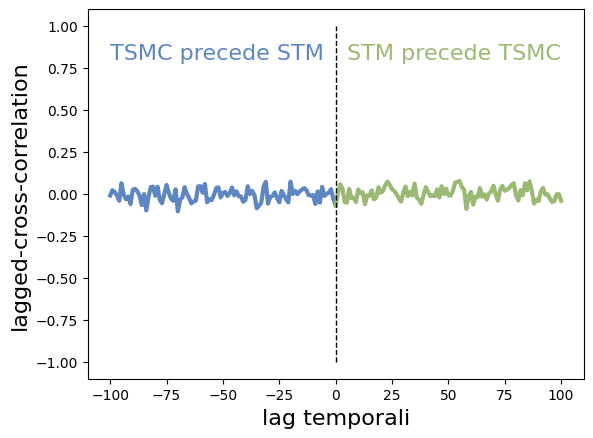

lag =  55
max corr =  0.07645020305936426


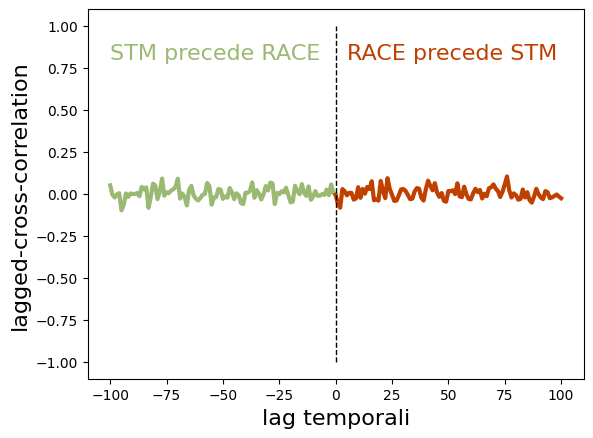

lag =  76
max corr =  0.10398619167126706


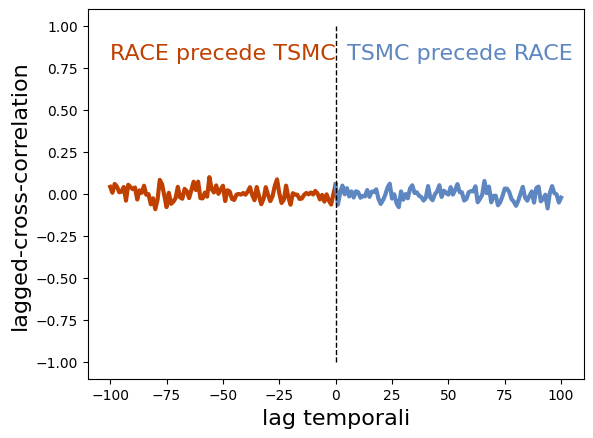

lag =  -56
max corr =  0.09976193680528693


In [1031]:
lag=100
corr1 = CrossCorrelationAnalysis(d_tsmc_shuffle,d_stm_shuffle, lag,1,color1='#5E86C1',color2='#9AB973',nome1='TSMC',nome2='STM',figname='corr1_shuffle')
corr2 = CrossCorrelationAnalysis(d_stm_shuffle,d_race_shuffle, lag,1,color1='#9AB973',color2='#C04000',nome1='STM',nome2='RACE',figname='corr2_shuffle')
corr3 = CrossCorrelationAnalysis(d_race_shuffle,d_tsmc_shuffle, lag,1,color1='#C04000',color2='#5E86C1',nome1='RACE',nome2='TSMC',figname='corr3_shuffle')

----------------
## GRANGER CAUSALITY
------------
------------

TROVO I LAG OTTIMALI 

-----------------

In [1032]:
def splitter(data_df):
    end = round(len(data_df)*.8)
    train_df = data_df[:end]
    test_df = data_df[end:]
    return train_df, test_df

def select_p(train_df):
    aic, bic, fpe, hqic = [], [], [], []
    model = VAR(train_df) 
    p = np.arange(1,30)
    for i in p:
        result = model.fit(i)
        aic.append(result.aic)
        bic.append(result.bic)
        fpe.append(result.fpe)
        hqic.append(result.hqic)
    lags_metrics_df = pd.DataFrame({'AIC': aic, 
                                    'BIC': bic, 
                                    'HQIC': hqic,
                                    'FPE': fpe}, 
                                   index=p)    
    fig, ax = plt.subplots(1, 4, figsize=(15, 3), sharex=True)
    lags_metrics_df.plot(subplots=True, ax=ax, marker='o')
    plt.tight_layout()
    print(lags_metrics_df.idxmin(axis=0))

AIC     14
BIC      4
HQIC     8
FPE     14
dtype: int64


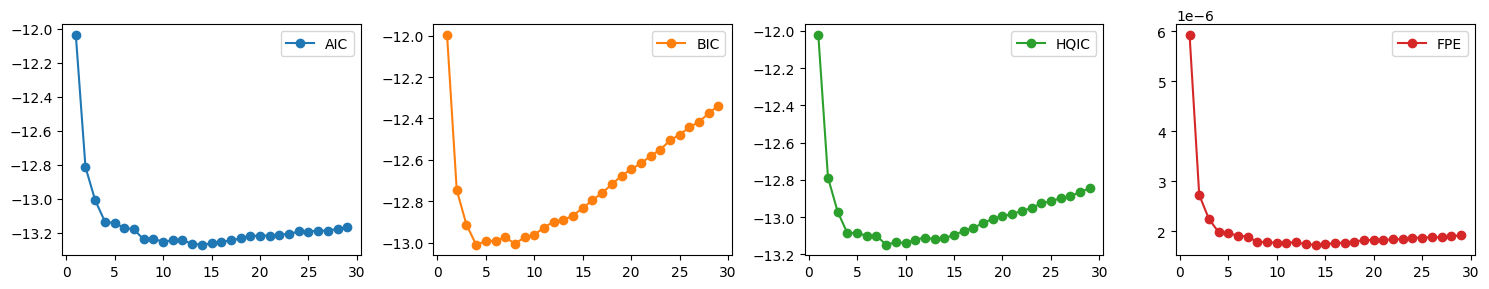

In [1033]:
data=pd.concat([pd.Series(d_stm),pd.Series(d_tsmc)], axis=1)
train_df, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_stm_tsmc.svg')

AIC     16
BIC      4
HQIC     8
FPE     16
dtype: int64


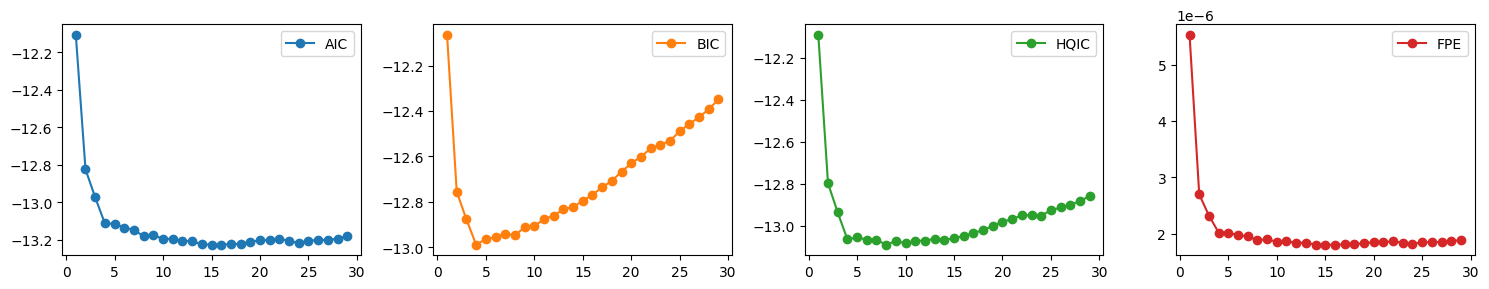

In [1034]:
data=pd.concat([pd.Series(d_stm),pd.Series(d_race)], axis=1)
train_df, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_stm_race.svg')

AIC     13
BIC      8
HQIC     8
FPE     13
dtype: int64


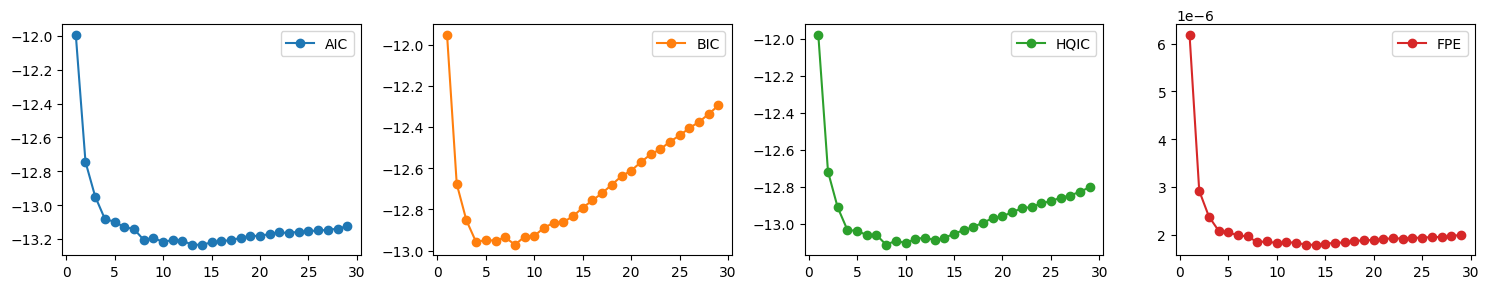

In [1035]:
data=pd.concat([pd.Series(d_tsmc),pd.Series(d_race)], axis=1)
train_df, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_race_tsmc.svg')

---------------
GC:  STM -> TSMC

--------------------

In [1]:
maxlag=[4]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_tsmc,'column2': d_stm})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')



NameError: name 'pd' is not defined

---------------
GC:  TSMC->STM

--------------------

In [1062]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_stm,'column2': d_tsmc})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')



Lag: 14
Granger causality p-value: 0.331657182125735


---------------
GC:  RACE->STM

--------------------

In [1069]:
maxlag=[4]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_stm,'column2': d_race})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')


Lag: 8
Granger causality p-value: 0.07272692542565944


---------------
GC:  STM->RACE

--------------------

In [1070]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_race,'column2': d_stm})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 8
Granger causality p-value: 0.016912892929653405


---------------
GC:  TSMC->RACE

--------------------

In [1065]:
maxlag=[8]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_race,'column2': d_tsmc})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.4970909865020092


---------------
GC:  RACE->TSMC

--------------------

In [1066]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_tsmc,'column2': d_race})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.0009201219182367985


---------
## CERCO VARIABILE NASCOSTA
-----------
----------

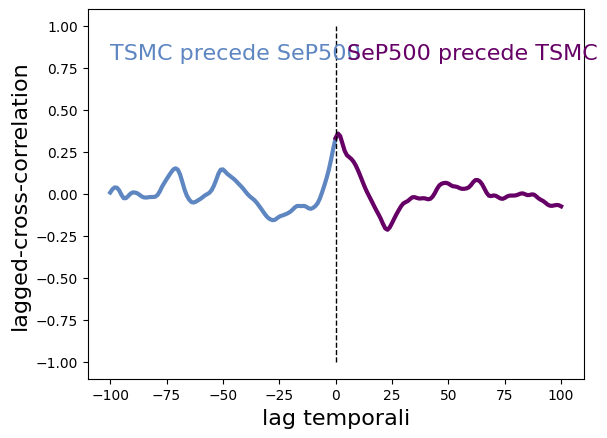

lag =  1
max corr =  0.3595552899549937


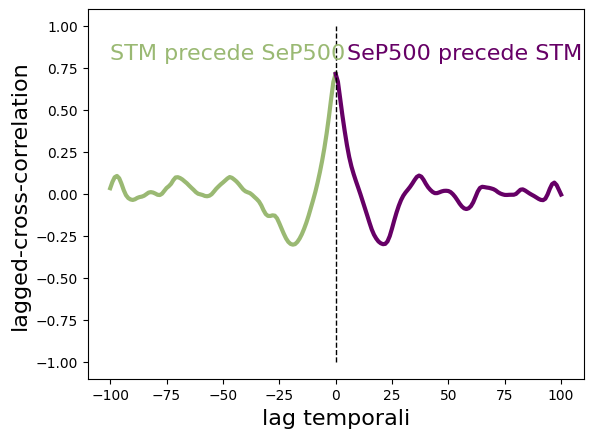

lag =  0
max corr =  0.7144641633247197


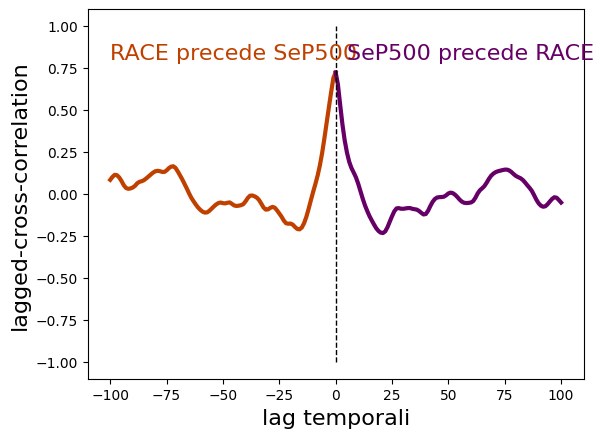

lag =  0
max corr =  0.7224314875099493


In [1042]:
lag=100
corr1 = CrossCorrelationAnalysis(d_tsmc,d_SeP500,lag,1,color1='#5E86C1',color2='#660066',nome1='TSMC',nome2='SeP500',figname='corrse1')
corr2 = CrossCorrelationAnalysis(d_stm,d_SeP500, lag,1,color1='#9AB973',color2='#660066',nome1='STM',nome2='SeP500',figname='corrse2')
corr3 = CrossCorrelationAnalysis(d_race,d_SeP500, lag,1,color1='#C04000',color2='#660066',nome1='RACE',nome2='SeP500',figname='corrse3')

---------
## GRANGER CAUSALITY
-------
-------

TROVO I LAG OTTIMALI 

-----------------

AIC     13
BIC      8
HQIC     8
FPE     13
dtype: int64


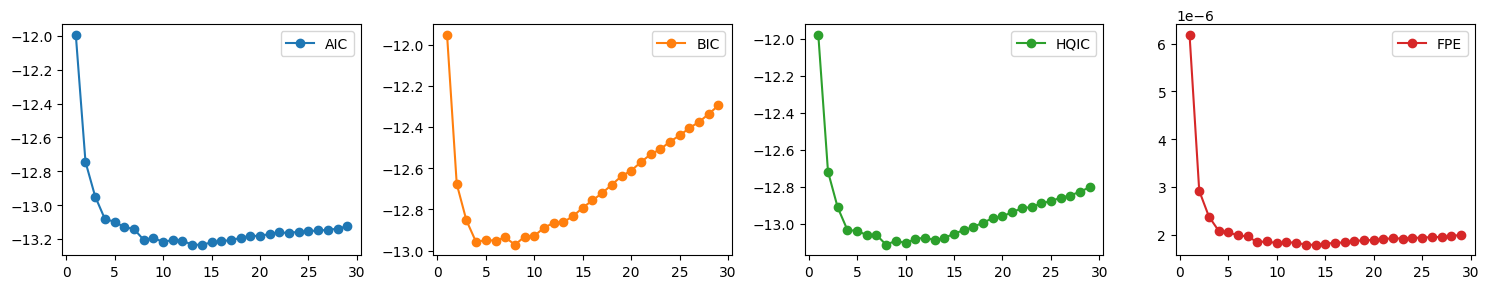

In [1043]:
data=pd.concat([stm,SeP500], axis=1)
traindf, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_stm_sep500.svg')

AIC     13
BIC      8
HQIC     8
FPE     13
dtype: int64


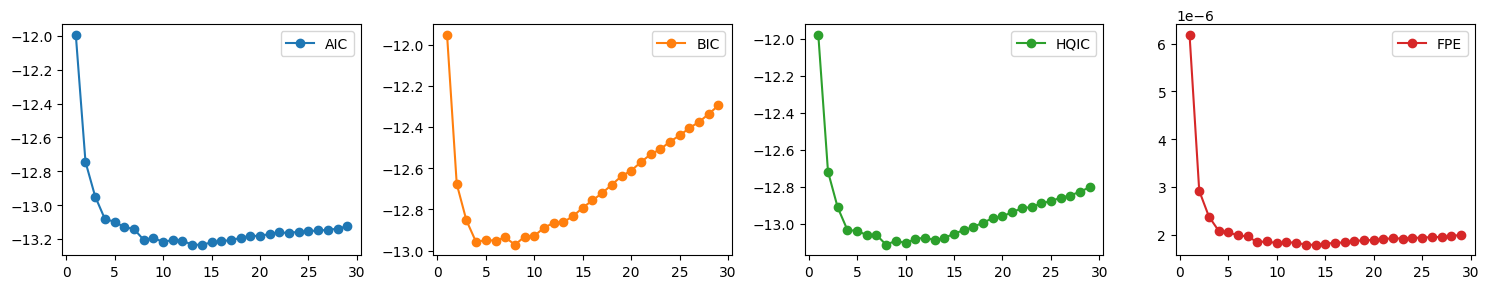

In [1044]:
data=pd.concat([tsmc,SeP500], axis=1)
traindf, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_tsmc_sep500.svg')

AIC     13
BIC      8
HQIC     8
FPE     13
dtype: int64


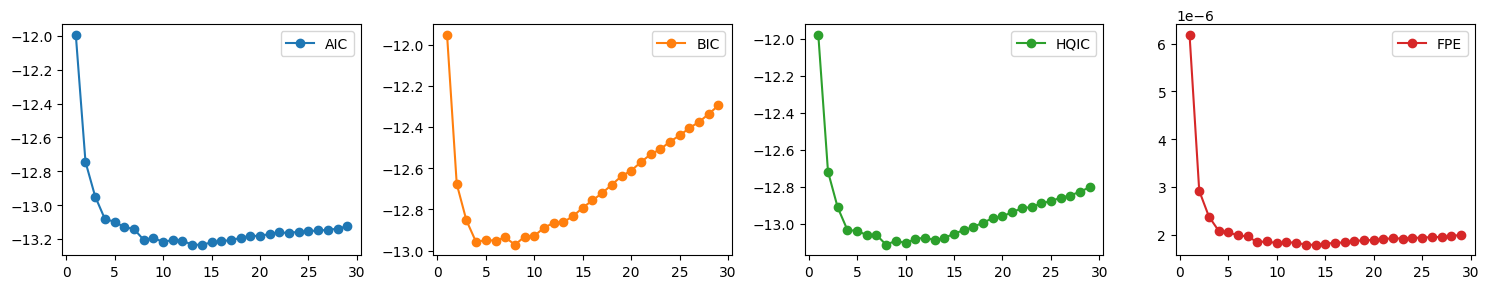

In [1045]:
data=pd.concat([race,SeP500], axis=1)
traindf, test_df = splitter(data)
select_p(train_df)
plt.savefig('aicbic_race_sep500.svg')

-----------
SeP500->STM

---------

In [1071]:
maxlag=[8]
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_stm,'column2': d_SeP500})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.07623523574505003


-----------
STM->SeP500

---------

In [1072]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_SeP500,'column2': d_stm})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.0015115918917396217


-----------
SeP500->TSMC

---------

In [1073]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_tsmc,'column2': d_SeP500})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 1.050784339106564e-06


-----------
TSMC->SeP500

---------

In [1074]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_SeP500,'column2': d_tsmc})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.7188188328782152


----------
SeP500->RACE

------------

In [1075]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_race,'column2': d_SeP500})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 2.1044720296150735e-05


-------
RACE->SeP500

--------

In [1076]:
# Creazione di un DataFrame di esempio con due serie temporali
data = pd.DataFrame({'column1': d_SeP500,'column2': d_race})
results = grangercausalitytests(data, maxlag,addconst=True,verbose=False)
# Visualizzazione dei risultati
for lag in results.keys():
    print(f'Lag: {lag}')
    print(f'Granger causality p-value: {results[lag][0]["ssr_ftest"][1]}')

Lag: 13
Granger causality p-value: 0.1071569510531628


------------------------
## CONTROLLO I RESIDUI PER AUTOCORRELAZIONE
------------------
-----------------------

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     10:58:57
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.1210
Nobs:                     822.000    HQIC:                  -13.1846
Log likelihood:           3120.38    FPE:                1.80647e-06
AIC:                     -13.2241    Det(Omega_mle):     1.76756e-06
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.023370         0.005713            4.090           0.000
L1.column1         1.667356         0.033836           49.278           0.000
L1.column2         0.173985         0.030222            5.757         

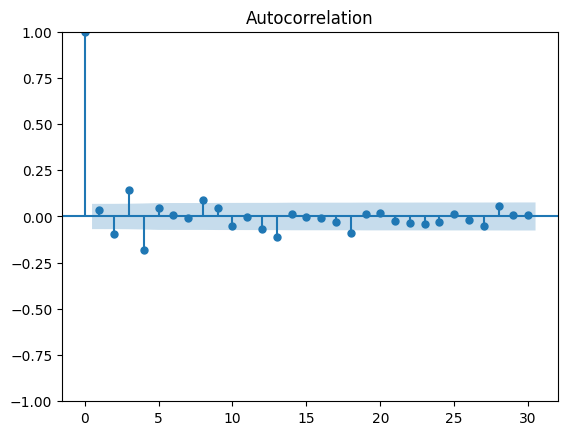

In [1052]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_tsmc,'column2': d_stm})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     10:58:58
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.1700
Nobs:                     822.000    HQIC:                  -13.2336
Log likelihood:           3140.54    FPE:                1.72001e-06
AIC:                     -13.2732    Det(Omega_mle):     1.68295e-06
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.046965         0.007396            6.350           0.000
L1.column1         1.673665         0.038214           43.798           0.000
L1.column2         0.123347         0.038814            3.178         

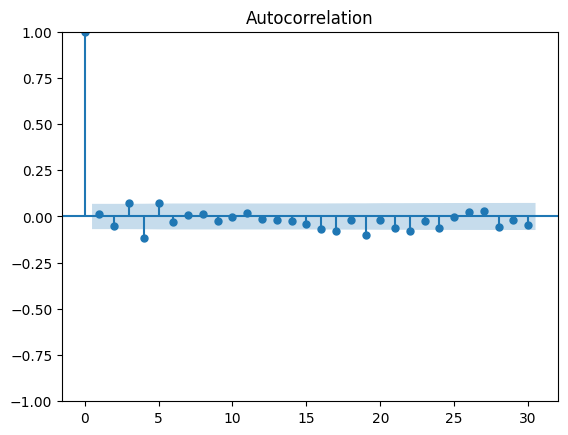

In [1053]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_stm,'column2': d_race})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     10:58:59
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.1015
Nobs:                     822.000    HQIC:                  -13.1651
Log likelihood:           3112.37    FPE:                1.84203e-06
AIC:                     -13.2046    Det(Omega_mle):     1.80235e-06
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.024152         0.007015            3.443           0.001
L1.column1         1.701630         0.033757           50.408           0.000
L1.column2         0.098142         0.031264            3.139         

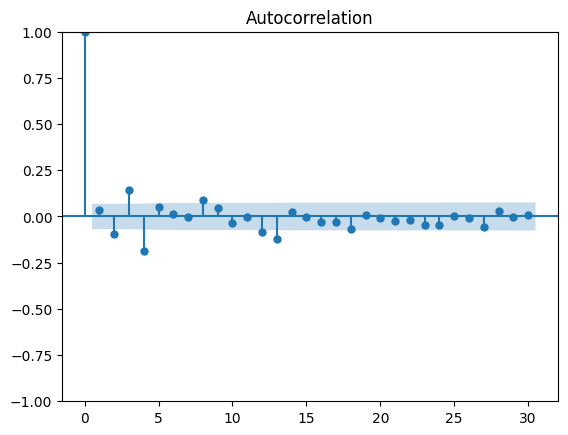

In [1054]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_tsmc,'column2': d_race})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     10:59:00
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.5095
Nobs:                     822.000    HQIC:                  -13.5731
Log likelihood:           3280.07    FPE:                1.22488e-06
AIC:                     -13.6127    Det(Omega_mle):     1.19849e-06
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.051353         0.008164            6.290           0.000
L1.column1         1.664233         0.041852           39.765           0.000
L1.column2         0.134952         0.046940            2.875         

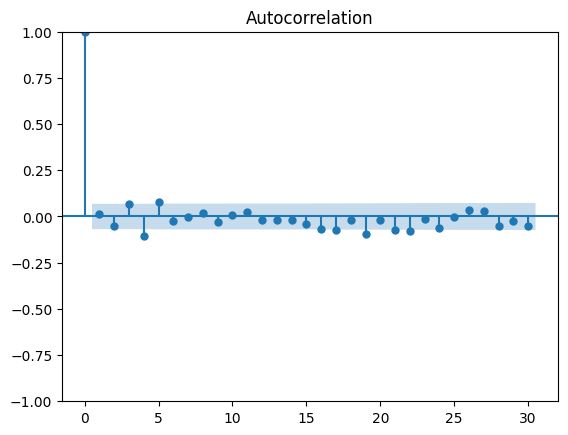

In [1055]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_stm,'column2': d_SeP500})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     10:59:01
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.2857
Nobs:                     822.000    HQIC:                  -13.3493
Log likelihood:           3188.11    FPE:                1.53203e-06
AIC:                     -13.3889    Det(Omega_mle):     1.49902e-06
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.020784         0.007703            2.698           0.007
L1.column1         1.695436         0.033592           50.472           0.000
L1.column2         0.138202         0.034173            4.044         

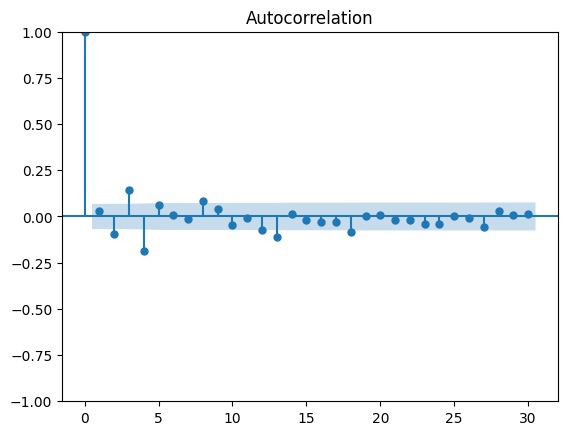

In [1056]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_tsmc,'column2': d_SeP500})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)



df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Tue, 25, Apr, 2023
Time:                     10:59:02
--------------------------------------------------------------------
No. of Equations:         2.00000    BIC:                   -13.7634
Nobs:                     822.000    HQIC:                  -13.8270
Log likelihood:           3384.43    FPE:                9.50218e-07
AIC:                     -13.8666    Det(Omega_mle):     9.29747e-07
--------------------------------------------------------------------
Results for equation column1
                coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------
const              0.062247         0.008269            7.528           0.000
L1.column1         1.763188         0.046969           37.539           0.000
L1.column2        -0.079022         0.052035           -1.519         

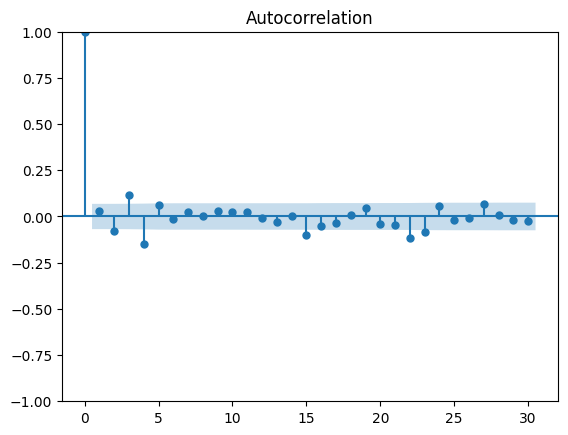

In [1057]:
# Esegui l'analisi causale utilizzando modelli VAR
data = pd.DataFrame({'column1': d_race,'column2': d_SeP500})
model = sm.tsa.VAR(data)
results = model.fit(maxlags=4, ic='aic')
print(results.summary())
residuals = results.resid['column1']
plot_acf(residuals)

df=data
model = sm.tsa.VAR(df)
results = model.fit(maxlags=20, ic='aic')
residuals = results.resid
#test residui per normalità
#Questa funzione esegue il test di Ljung-Box sui residui. Il parametro "lags" specifica il numero di ritardi da includere nel test.
print('jung-box =')
print(sm.stats.acorr_ljungbox(residuals['column1'], lags=20))